scripts > smstask > run_smstask.py

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
""" SMS training (metronome -> sinusoid target). """

import sys, os
import inspect
import numpy as np
import torch
from ignite.engine import Events
from sacred import Experiment
from sacred.observers import FileStorageObserver

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
if parentdir not in sys.path:
    sys.path.insert(0, parentdir)

# import ingredients (names match your project layout)
from ingredients.dataset import smstask as dataset, load_sms as load_dataset  # dataset ingredient + load function
from ingredients.model import model, init_model
from ingredients.training import training, init_metrics, init_optimizer, \
    create_rnn_trainer, create_rnn_evaluator, Tracer, ModelCheckpoint

import logging
logging.getLogger("ignite").setLevel(logging.WARNING)


# configs
training.add_config('configs/training.yaml')
model.add_config('configs/model.yaml')
dataset.add_config('configs/dataset.yaml')  # new config

OBSERVE = False
nepochs = 2
seed = 123
temp_path = 'sims/temp'
ex_name = 'sms'
ex = Experiment(name=ex_name, ingredients=[dataset, model, training])
ex.add_config(no_cuda=False, save_folder=temp_path, experiment_name=ex_name)
ex.add_package_dependency('torch', torch.__version__)
if OBSERVE:
    ex.observers.append(FileStorageObserver.create('sims'))

@ex.capture
def set_seed_and_device(seed, no_cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available() and not no_cuda:
        torch.cuda.manual_seed(seed)
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')
    return device

@ex.main
def main(_config, seed):
    no_cuda = _config['no_cuda']
    epochs = _config['training']['epochs']

    input_size = 1                 # metronome
    output_size = 1                # 1D sinusoid
    seq_len = _config['dataset']['seq_len']
    classification = False
    predict_last = False

    log_interval = max(1, epochs // 10)
    batch_size = _config['training']['batch_size']

    loss, metrics = init_metrics('mse', ['mse'])
    device = set_seed_and_device(seed, no_cuda)

    training_set, validation_set, test_set = load_dataset(
        batch_size=batch_size,
        **_config['dataset']            # pass through dataset cfg block
    )
    model_inst = init_model(input_size=input_size, output_size=output_size)
    model_inst.init_dataset_details(batch_size, seq_len, classification, predict_last)
    model_inst = model_inst.to(device)
    optimizer = init_optimizer(model=model_inst)

    trainer = create_rnn_trainer(model_inst, optimizer, loss, device=device)
    validator = create_rnn_evaluator(model_inst, metrics, device=device)

    @trainer.on(Events.EPOCH_STARTED)
    def on_epoch(engine):
        nepoch = engine.state.epoch
        if nepoch % log_interval == 0:
            print("#" * 75)
            print(f"Epoch: {nepoch}")
            print("#" * 75)

    @trainer.on(Events.EPOCH_COMPLETED)
    def validate(engine):
        validator.run(validation_set)

    @trainer.on(Events.EXCEPTION_RAISED)
    def terminate(engine, exception):
        if isinstance(exception, KeyboardInterrupt):
            engine.should_terminate = True

    tracer = Tracer(metrics).attach(trainer)

    @trainer.on(Events.EPOCH_COMPLETED)
    def log_training(engine):
        ex.log_scalar('training_loss', tracer.loss[-1])
        tracer.loss.clear()

    @validator.on(Events.EPOCH_COMPLETED)
    def log_validation(engine):
        for metric, value in engine.state.metrics.items():
            if 'mse' in metric and not model_inst.predict_last:
                value = value / seq_len
                if metric == 'mse':
                    value = value / output_size
            print("Val loss:", value)
            ex.log_scalar('val_{}'.format(metric), value)

    def score_fn(engine):
        return -engine.state.metrics[list(metrics)[0]]

    global checkpoint
    checkpoint = ModelCheckpoint(
        dirname=_config['save_folder'],
        filename_prefix='sms',
        score_function=score_fn,
        create_dir=True,
        require_empty=False,
        save_as_state_dict=True
    )

    validator.add_event_handler(Events.COMPLETED, checkpoint, {'model': model_inst})

    print("starting training")
    trainer.run(training_set, max_epochs=epochs)
    print("finished training")

    model_inst.eval()
    model_inst.load_state_dict(checkpoint.best_model)
    tester = create_rnn_evaluator(model_inst, metrics, device=device)
    test_metrics = tester.run(test_set).metrics
    for metric, value in test_metrics.items():
        print("Test {}: {}".format(metric, value))
    ex.add_artifact(checkpoint.last_checkpoint, 'best-model.pt')
    os.remove(checkpoint.last_checkpoint)

if __name__ == "__main__":
    r = ex.run(config_updates={'training': {'epochs': nepochs},
                               'model': {'apply_cerebellum': True},
                               'seed': seed})


Dataset Config:


In [ ]:
# sensorimotor synchronization (metronome → sinusoid)
seq_len: 200            # 20 s at 100 ms/step (adjust as needed)
training_size: 1000
test_size: 1000
train_val_split: 0.2
fixdata: False          # set True to pre-materialize a fixed dataset
train_noise_var: 0.05   # additive noise on tick channel (optional)
test_noise_var: 0.0

# SMS specifics
tempo_steps: 5          # 1 tick every 5 steps (500 ms)
jitter_prob: 0.2        # chance to phase-jitter a sequence
max_jitter: 1           # jitter in steps
variable_tempo: False   # set True to train across tempi
tempo_min: 4            # when variable_tempo=True, sample K∈[4,8]
tempo_max: 8


Model Config:

In [ ]:
# SMS model configuration (metronome -> sinusoid)
rnn_type: 'RNN_eprop'   # match your repo’s default
n_layers: 1
hidden_size: 50         # same as linedraw; feel free to try 64-96 later
input_size: 1           # 1D input (metronome tick stream)
output_size: 1          # 1D output (sinusoid in [0,1])
evec_scale: null
readout_from_cereb: False
apply_cerebellum: True  # turn cerebellum on (set False to compare)
bias: False
fixed_rnn: True
alpha: 0.1              # 100 ms step -> 0.1 matches paper’s discrete-time choice

cereb_params:
  # Pons fan-in sizes (if your code uses them; keep defaults from linedraw)
  pons_sizes:
    PFC_pons_size: null
    MC_pons_size: 0
    targ_pons_size: 0
    inp_pons_size: 0

  # IO (inferior olive) pathway sizes (use linedraw defaults)
  IO_sizes:
    PFC_IO_size: 0
    MC_IO_size: 0
    targ_IO_size: null
    inp_IO_size: 0

  # IO delays in **timesteps** (100 ms each). These set the cerebellar timing window.
  # For SMS with a 500 ms period (5 steps), a 2–3 step delay is a good starting point.
  IO_delays:
    PFC_IO_delay: 5   # unused here; keep defaults
    MC_IO_delay: 3    # motor-cortex teaching delay
    targ_IO_delay: 3  # target teaching delay
    inp_IO_delay: 2   # sensory-to-IO delay

  hidden_size: 1000     # cerebellum hidden units (as in linedraw)
  num_hidden_layers: 1
  nfibres: null
  zero_output: False
  bias: False
  do_final_learning: False
  temp_basis: False

Training Config:

In [ ]:
epochs: 250            # same as linedraw; you can drop to 150 once it’s stable
batch_size: 10         # mirrors linedraw; try 32 for speed if memory allows
optimizer: adam
lr_rnn: 0.001
lr_readout: 0.001
lr_cerebellum: 0.001
l2_norm: 0.0
rate_reg: 0.0
clip: 1.0
keep_hidden: False

Source Dataset:

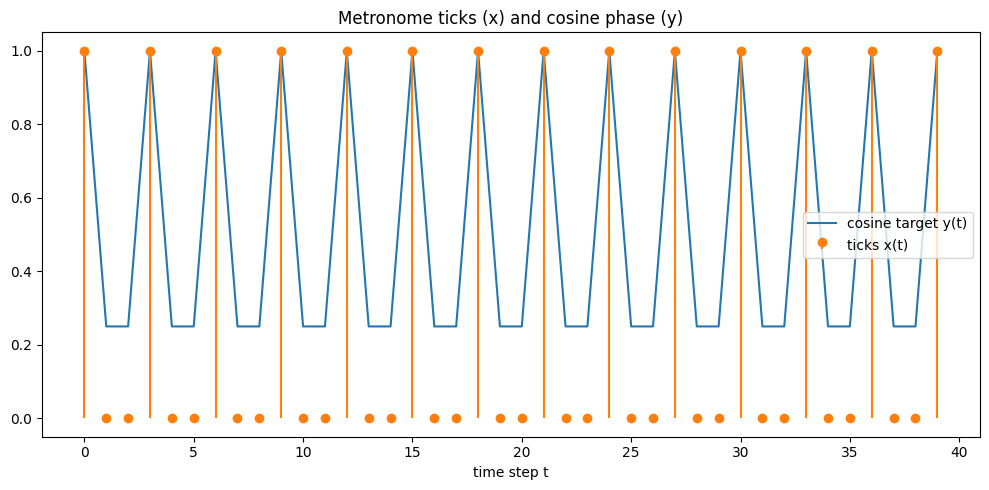

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-


import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset

def _make_sequence(T, tempo_steps, jitter_prob=0.0, max_jitter=1, rng=None):
    if rng is None:
        rng = np.random.RandomState(None)

    # Phase jitter (in steps)
    phase = 0
    if jitter_prob > 0 and rng.rand() < jitter_prob:
        phase = rng.randint(-max_jitter, max_jitter + 1)

    # Input is a binary metronome
    x = np.zeros((T, 1), dtype=float)
    for t in range(T):
        if ((t - phase) % tempo_steps) == 0:
            x[t, 0] = 1.0

    # Target: cosine in [0,1] with peaks at tick times
    y = np.zeros((T, 1), dtype=float)
    for t in range(T):
        theta = 2.0 * np.pi * ((t - phase) % tempo_steps) / tempo_steps
        y[t, 0] = 0.5 * (np.cos(theta) + 1.0)

    return x, y

def _sample_batch(
    batch_size,
    seq_len,
    tempo_steps,
    rng=None,
    tick_noise_var=0.0,
    jitter_prob=0.0,
    max_jitter=1,
    variable_tempo=False,
    tempo_min=4,
    tempo_max=8,
):
    if rng is None or isinstance(rng, int):
        rng = np.random.RandomState(rng)

    xs = np.zeros((batch_size, seq_len, 1), dtype=float)
    ys = np.zeros((batch_size, seq_len, 1), dtype=float)

    for b in range(batch_size):
        K = tempo_steps
        if variable_tempo:
            K = int(rng.randint(tempo_min, tempo_max + 1))
            K = max(2, K)
        x, y = _make_sequence(
            seq_len, K, jitter_prob=jitter_prob, max_jitter=max_jitter, rng=rng
        )
        if tick_noise_var > 0:
            x = x + rng.randn(*x.shape) * tick_noise_var
            x = np.clip(x, 0.0, 1.0)  # keep in [0,1] if you prefer

        xs[b] = x
        ys[b] = y

    return xs, ys

class BatchGeneratorSMS:
    def __init__(
        self,
        size=1000,
        batch_size=128,
        seq_len=200,
        tempo_steps=5,
        tick_noise_var=0.0,
        jitter_prob=0.0,
        max_jitter=1,
        variable_tempo=False,
        tempo_min=4,
        tempo_max=8,
        offline_data=False,
        random_state=None,
    ):
        self.size = size
        self.batch_size = batch_size
        self.seq_len = seq_len
        self.tempo_steps = tempo_steps
        self.tick_noise_var = tick_noise_var
        self.jitter_prob = jitter_prob
        self.max_jitter = max_jitter
        self.variable_tempo = variable_tempo
        self.tempo_min = tempo_min
        self.tempo_max = tempo_max
        self.offline_data = offline_data

        if random_state is None or isinstance(random_state, int):
            random_state = np.random.RandomState(random_state)
        self.rng = random_state
        self.init_state = random_state.get_state()

    def __len__(self):
        return int(np.ceil(self.size / self.batch_size))

    def __iter__(self):
        for _ in range(len(self)):
            yield self.next_batch()
        if self.offline_data:
            self.reset()

    def reset(self):
        self.rng.set_state(self.init_state)

    def next_batch(self):
        x, y = _sample_batch(
            batch_size=self.batch_size,
            seq_len=self.seq_len,
            tempo_steps=self.tempo_steps,
            rng=self.rng,
            tick_noise_var=self.tick_noise_var,
            jitter_prob=self.jitter_prob,
            max_jitter=self.max_jitter,
            variable_tempo=self.variable_tempo,
            tempo_min=self.tempo_min,
            tempo_max=self.tempo_max,
        )
        x = torch.as_tensor(x, dtype=torch.float32)
        y = torch.as_tensor(y, dtype=torch.float32)
        return x, y

    def torch_dataset(self):
        curr = self.rng.get_state()
        self.rng.set_state(self.init_state)
        batches = [batch for batch in self]
        self.rng.set_state(curr)
        xs, ys = zip(*batches)
        data = TensorDataset(torch.cat(xs), torch.cat(ys))
        return DataLoader(dataset=data, batch_size=self.batch_size, shuffle=True)

def load_smstask(
    training_size,
    test_size,
    batch_size,
    seq_len,
    train_val_split=0.2,
    train_noise_var=0.0,   # noise on ticks
    test_noise_var=0.0,
    fixdata=False,
    random_state=None,

    # SMS-specific:
    tempo_steps=5,
    jitter_prob=0.0,
    max_jitter=1,
    variable_tempo=False,
    tempo_min=4,
    tempo_max=8,
):

    N = int(training_size * (1 - train_val_split))
    val_size = training_size - N

    if random_state is None:
        train_rng = np.random.randint(2**16 - 1)
        val_rng = np.random.randint(2**16 - 1)
        test_rng = np.random.randint(2**16 - 1)
    else:
        if isinstance(random_state, int):
            random_state = np.random.RandomState(random_state)
        train_rng = random_state.randint(2**16 - 1)
        val_rng = random_state.randint(2**16 - 1)
        test_rng = random_state.randint(2**16 - 1)

    train_gen = BatchGeneratorSMS(
        size=training_size, batch_size=batch_size, seq_len=seq_len,
        tempo_steps=tempo_steps, tick_noise_var=train_noise_var,
        jitter_prob=jitter_prob, max_jitter=max_jitter,
        variable_tempo=variable_tempo, tempo_min=tempo_min, tempo_max=tempo_max,
        offline_data=fixdata, random_state=train_rng,
    )

    val_gen = BatchGeneratorSMS(
        size=val_size, batch_size=val_size, seq_len=seq_len,
        tempo_steps=tempo_steps, tick_noise_var=train_noise_var,
        jitter_prob=jitter_prob, max_jitter=max_jitter,
        variable_tempo=variable_tempo, tempo_min=tempo_min, tempo_max=tempo_max,
        offline_data=fixdata, random_state=val_rng,
    )

    test_gen = BatchGeneratorSMS(
        size=test_size, batch_size=test_size, seq_len=seq_len,
        tempo_steps=tempo_steps, tick_noise_var=test_noise_var,
        jitter_prob=0.0, max_jitter=max_jitter,  # usually no jitter in test
        variable_tempo=variable_tempo, tempo_min=tempo_min, tempo_max=tempo_max,
        offline_data=fixdata, random_state=test_rng,
    )

    if fixdata:
        train_gen = train_gen.torch_dataset()
        val_gen = val_gen.torch_dataset()
        test_gen = test_gen.torch_dataset()

    return train_gen, val_gen, test_gen

#

if __name__ == "__main__":
    import matplotlib.pyplot as plt

    # 1) Generate ONE sequence
    T = 40          # sequence length
    tempo_steps = 3 # tick every 5 steps

    x, y = _make_sequence(T, tempo_steps)

    t = np.arange(T)  # time axis: 0, 1, 2, ..., T-1

    # 2) Plot
    plt.figure(figsize=(10, 5))

    # Plot cosine target y
    plt.plot(t, y[:, 0], label="cosine target y(t)")

    # Plot metronome ticks x as vertical stems
    plt.stem(t, x[:, 0], linefmt="C1-", markerfmt="C1o", basefmt=" ", label="ticks x(t)")

    plt.xlabel("time step t")
    plt.legend()
    plt.title("Metronome ticks (x) and cosine phase (y)")
    plt.tight_layout()
    plt.show()








train_gen = training data (training)
val_gen = validation data (practice exam)
test_gen = test data (final exam)